In [1]:
import pandas as pd
import statistics
import os
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from plotly.offline import init_notebook_mode, iplot, plot
import plotly as py
init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.express as px
import statistics as stat
from scipy.stats import binom
from sklearn.preprocessing import StandardScaler
from matplotlib.patches import Rectangle
# splitting merge_data into train test and split
from sklearn.model_selection import train_test_split, cross_validate
from scipy import stats
from scipy.stats import normaltest
import os 
from sklearn.preprocessing import MinMaxScaler
from sklearn import preprocessing
import matplotlib as mpl
import warnings; warnings.filterwarnings(action='once')
# to keep track of training time
import datetime
# logistic regression model
from sklearn.linear_model import LogisticRegression
# metrics used for evaluation
from sklearn.metrics import f1_score, matthews_corrcoef
# visualizations
from yellowbrick.classifier import ClassPredictionError, ConfusionMatrix
from sklearn.metrics import plot_roc_curve
# KNN imputation
from sklearn.impute import KNNImputer
# normalizer
from sklearn.preprocessing import Normalizer
# variance threshold
from sklearn.feature_selection import VarianceThreshold
# RFECV
from sklearn.model_selection import StratifiedKFold
# random forest
from sklearn.ensemble import RandomForestClassifier
# evaluation metric
from sklearn.metrics import matthews_corrcoef, make_scorer
from scipy import stats 
from sklearn.model_selection import KFold, StratifiedKFold, train_test_split 
from sklearn.model_selection import cross_val_score # Evaluate a score by cross-validation
from sklearn.model_selection import GridSearchCV # Exhaustive search over specified parameter values for an estimator
from sklearn.metrics import classification_report # Build a text report showing the main classification metrics
from sklearn.metrics import accuracy_score # Accuracy classification score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay # to show confusion matrix
from sklearn import metrics # Evaluate ROC curve
from sklearn.experimental import enable_iterative_imputer # Enables IterativeImputer. The API and results of this estimator might change without any deprecation cycle
from sklearn.impute import IterativeImputer
from imblearn.combine import SMOTEENN # Combine over- and under-sampling using SMOTE and Edited Nearest Neighbours
from sklearn import decomposition
from boruta import BorutaPy
from imblearn.over_sampling import SMOTE, ADASYN, RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
from sklearn.metrics import plot_confusion_matrix
from matplotlib.colors import ListedColormap

Read files 

In [2]:
def read_secom():
    path ='../secom.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['feature'+str(x+1) for x in range(len(df.columns))]
    return df

#%%
def read_labels():
    path = '../secom_labels.data'
    df = pd.read_csv(path, delimiter=' ', header=None, na_values=['NaN'])
    df.columns = ['status','timestamp']
    df['timestamp'] = pd.to_datetime(df['timestamp'],dayfirst=True)
    return df

#read 2 df 
df_features = read_secom()
df_target = read_labels()

# Data Preparation

## Merge data

In [3]:
df= pd.concat([df_features,df_target],axis=1)

## Split Training and test data 

In [4]:
x = df.iloc[:,:590]
y = df.iloc[:,590]
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.2, random_state = 1,stratify=y)

In [5]:
x_train.isna().sum().sum()

33219

## reducing dimensionality 

### remove missing values 

In [6]:
def null_values(df):
    """a function to show null values with percentage"""
    nv=pd.concat([df.isnull().sum(), 100 * df.isnull().sum()/df.shape[0]],axis=1).rename(columns={0:'Missing_Records', 1:'Percentage (%)'})
    return nv[nv.Missing_Records>0].sort_values('Missing_Records', ascending=False)

In [7]:
x_train_na = null_values(x_train)
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
...,...,...
feature500,1,0.079808
feature367,1,0.079808
feature377,1,0.079808
feature378,1,0.079808


In [8]:
miss_threshold=80
x_train_na= x_train_na[x_train_na["Percentage (%)"] > miss_threshold]
x_train_na

,Missing_Records,Percentage (%)
feature293,1144,91.300878
feature158,1144,91.300878
feature159,1144,91.300878
feature294,1144,91.300878
feature221,1072,85.554669
feature86,1072,85.554669
feature359,1072,85.554669
feature493,1072,85.554669


In [9]:
x_train_new = x_train.drop(axis=1, columns=x_train_na.index)
x_train_new.shape

(1253, 582)

### removing constant voltality

In [10]:
x_train_new_eda= x_train_new.describe().T
x_train_new_eda

,count,mean,std,min,25%,50%,75%,max
feature1,1248.0,3014.113686,73.877303,2743.2400,2966.2300,3011.40500,3056.310000,3356.3500
feature2,1247.0,2496.400585,79.188651,2162.8700,2452.3350,2500.38000,2539.600000,2846.4400
feature3,1243.0,2200.216525,29.939025,2060.6600,2180.8611,2200.98890,2218.055500,2315.2667
feature4,1243.0,1394.907987,436.632421,0.0000,1083.8858,1283.43680,1593.122000,3715.0417
feature5,1243.0,4.018582,54.572445,0.6815,1.0160,1.31710,1.525700,1114.5366
...,...,...,...,...,...,...,...,...
feature586,1252.0,3.084501,3.968128,1.1975,2.3058,2.74655,3.258475,99.3032
feature587,1252.0,0.021521,0.012421,-0.0060,0.0134,0.02070,0.027600,0.1028
feature588,1252.0,0.016344,0.008698,0.0042,0.0106,0.01480,0.019800,0.0799
feature589,1252.0,0.005248,0.002850,0.0012,0.0033,0.00460,0.006300,0.0286


In [11]:
x_train_new_eda[x_train_new_eda['std']==0]
x_train_new_std= x_train_new_eda[x_train_new_eda["std"] == 0]
x_train_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,1243.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,1251.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,1253.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,1253.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,1253.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,1247.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
x_train_new_2 = x_train_new.drop(axis=1, columns=x_train_new_std.index)
x_train_new_2.shape

(1253, 466)

## Outlier Treatment

In [13]:
x_train_3s=x_train_new_2.copy()

In [14]:
def zscore(df,cols,thr):
    for col in cols:
        mean=df[col].mean()
        std=df[col].std()
        upper_bound=mean+ thr*std
        lower_bound=mean- thr*std
        df[col]=np.where(df[col]>upper_bound,upper_bound,np.where(df[col]<lower_bound,lower_bound,df[col]))

In [15]:
zscore(x_train_3s,x_train_3s.columns,3)

# Checking

In [16]:
x_train_new_2['feature4'].mean()

1394.907986725665

In [17]:

x_train_new_2['feature4'].std()

436.63242083048897

In [18]:
x_train_new_2['feature4'].mean()+3*x_train_new_2['feature4'].std()

2704.805249217132

In [19]:
x_train_new_2['feature4'].max()

3715.0417

In [20]:
x_train_3s['feature4'].max()


2704.805249217132

## Imputation

### KNN Imputation

In [21]:
# scaling before distanced based algo
#scaler = MinMaxScaler()
#x_train_scaled = pd.DataFrame(scaler.fit_transform(x_train_3s), columns=x_train_3s.columns)
#x_train_scaled

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.648120,0.201366,0.538010,0.452172,0.006439,0.392017,0.787343,0.527160,0.680406,0.663699,...,0.345437,0.190010,0.514663,0.075172,0.110693,0.071958,0.527907,0.397495,0.373085,0.182951
1,0.471228,0.489118,0.250017,0.318042,0.003555,0.606695,0.806973,0.430272,0.451391,0.514345,...,NaN,NaN,0.224461,0.208979,0.166039,0.205512,0.353482,0.611932,0.547721,0.436456
2,0.564671,0.250573,0.351025,0.514797,0.002089,0.753605,0.865862,0.613416,0.734617,0.735677,...,NaN,NaN,0.319527,0.081186,0.110693,0.079049,0.413682,0.640698,0.627101,0.368023
3,0.510211,0.300896,0.632400,0.543962,0.005265,0.467181,0.715366,0.483910,0.387223,0.678095,...,0.191093,0.137507,0.744823,0.061641,0.089938,0.057659,0.530994,0.258894,0.206388,0.132398
4,0.513934,0.368646,0.597947,0.633548,0.001678,0.476510,0.777528,0.610033,0.401606,0.399181,...,NaN,NaN,0.559694,0.130800,0.124529,0.125897,0.347307,0.188287,0.246077,0.183597
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,0.597451,0.468702,0.581926,0.602601,0.002028,0.483641,0.872406,0.581040,0.146039,0.582724,...,NaN,NaN,0.694788,0.172896,0.145284,0.165038,0.498579,0.196132,0.166698,0.118079
1249,0.490065,0.645495,0.636173,0.467074,0.004245,0.502029,0.744811,0.486810,0.421520,0.359593,...,NaN,NaN,0.404586,0.027062,0.041510,0.027184,0.517102,0.452412,0.508031,0.207902
1250,0.545630,0.784278,0.382138,0.741741,0.005230,0.349415,0.829874,0.448393,0.563133,0.661900,...,NaN,NaN,0.349548,0.102234,0.117611,0.100454,0.552604,0.193517,0.214325,0.103733
1251,0.525033,0.514521,0.385973,1.000000,0.004806,0.000000,0.875677,0.304874,0.431477,0.436969,...,0.029399,0.127442,0.604725,0.147337,0.172957,0.141052,0.277846,0.033996,0.031752,0.122707


In [16]:
# impute missing values and save it as a temporary dataset.
# no need to use scalr before applying teh KNN model , fit_transform fits and scales automatically
#use fit_transform on training data and only transform on test data
knn = KNNImputer()
#knn.fit(x_train_scaled)
imputed_train = pd.DataFrame(knn.fit_transform(x_train_3s), columns = x_train_3s.columns)

# Checking

In [17]:
imputed_train.isna().sum().sum()

0

## Feature Selection

In [21]:
#NOTE: no need to retransform /unscale
#retransformed_train= pd.DataFrame(scaler.inverse_transform(imputed_train), columns=imputed_train.columns)

## BORUTA

In [18]:
#Boruta function

def BorutaFeatureSelection (X, y,bor_iter) :
    feature_names = np.array(X.columns)

    # define random forest classifier
    model = RandomForestClassifier(n_jobs=-1, class_weight='balanced_subsample', max_depth=5, random_state=100)
    model.fit(X, y)
    
    # define Boruta feature selection method
    feature_selector = BorutaPy(model, n_estimators='auto', verbose=2, random_state=100, max_iter=bor_iter)

    # find all relevant features
    feature_selector.fit(X.to_numpy(),y)

    # check selected features
    feature_selector.support_

    # check ranking of features
    feature_ranking=feature_selector.ranking_

    # zip feature names, ranks, and decisions 
    feature_ranks = list(zip(feature_names, 
                             feature_selector.ranking_, 
                             feature_selector.support_))

    # print the results
    for feat in feature_ranks:
        print('Feature: {:<30} Rank: {},  Keep: {}'.format(feat[0], feat[1], feat[2]))
        
    final_features = list()
    indexes = np.where(feature_selector.ranking_ <= 1)
    for x in np.nditer(indexes):
        final_features.append(feature_names[x])
    print(final_features)
    
 # call transform() on X to filter it down to selected features
    return pd.DataFrame(X.filter(final_features)) , final_features, feature_ranking

In [19]:
# apply Boruta and store selected features in a variable
#X_train , final_features = BorutaFeatureSelection(imputed_train,y_train,145)
# boruta on reversed scaled data 
X_train , final_features, feature_ranking = BorutaFeatureSelection(imputed_train,y_train,140)# 132 iterations result in 14

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:260: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:265: DeprecationWarning:

`np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecat

Iteration: 	1 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	2 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	3 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	4 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	5 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	6 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	7 / 140
Confirmed: 	0
Tentative: 	466
Rejected: 	0
Iteration: 	8 / 140
Confirmed: 	0
Tentative: 	17
Rejected: 	449
Iteration: 	9 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	10 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	11 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	12 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	13 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	14 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	15 / 140
Confirmed: 	1
Tentative: 	16
Rejected: 	449
Iteration: 	16 / 140
Confirmed: 	4
Tentat

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:319: DeprecationWarning:

`np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations

c:\Users\hinat\anaconda3\lib\site-packages\boruta\boruta_py.py:325: DeprecationWarning:

`np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


# Checking

In [20]:
feature_ranking

array([  1, 400, 162, 147, 406, 321, 170,  59, 321, 151, 125, 275, 103,
       286,  49,  52, 358,   1, 394,   1, 293, 424,  93, 174, 325, 135,
        14, 282, 204,  16, 118,   1, 318, 157, 242, 101, 142, 211,  39,
        76, 325, 301, 167, 341, 199, 181, 395, 148, 318, 416, 116,  47,
       288,  50,   1, 249, 184, 163,  57,   3,  11, 110,  84, 165, 166,
       397, 223, 189, 449, 337,  28, 329,  16, 112,  93,  78, 343, 132,
       409, 312, 346, 392, 414,   6,  22, 197, 407, 440, 440, 180, 289,
       223, 435, 439,  62,   2, 395, 309, 368, 237, 415, 109, 348,  38,
        79, 356, 444,  20, 279,   4, 303, 191,  74,   1,  60,  79,   7,
        29,  10, 112, 238,   1,   1, 417,  95,  19, 420, 121, 353, 117,
       209,  65, 373, 370,  88, 163, 357, 152,  34, 277, 245, 376,   5,
         1, 316, 155, 199, 138,  61,  74, 296,  36, 106, 235, 431, 426,
       320, 304, 215, 419, 137, 405,  91, 210, 220, 341,  24, 259, 146,
        35, 177, 408, 255,  68,  48, 207, 138, 282, 317, 149, 19

,feature1,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature154,feature206,feature248,feature342,feature349,feature478,feature520
0,3079.77,12.3686,-4750.75,8.6915,0.6991,15.76,0.0000,0.8203,0.0127,9.22,0.015200,2.6547,0.02370,6.0266,3.292400
1,3001.36,12.4959,-5410.75,8.3006,-1.4173,15.76,0.2838,0.8291,0.0065,7.31,0.054460,2.0989,0.02720,4.8218,11.584860
2,3042.78,12.5553,-6456.75,8.7418,10.2355,15.65,-0.2838,0.5438,0.0148,8.80,0.034500,2.5012,0.01630,6.1589,7.439200
3,3018.64,12.4469,-5775.00,8.6829,9.8518,15.73,0.0473,0.8048,0.0159,7.77,0.260816,2.4329,0.03000,5.0612,61.263283
4,3020.29,12.4618,-6900.50,8.5891,1.0336,15.90,0.4258,0.7611,0.0078,11.06,0.034680,3.2653,0.02430,7.4828,7.412560
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1248,3057.31,12.4824,-6451.75,9.1156,3.2964,15.96,-0.9461,0.7527,0.0091,6.83,0.032820,1.8996,0.02640,4.6390,7.059080
1249,3009.71,12.5280,-5470.25,8.4278,3.0345,15.79,-0.4258,0.7217,0.0055,9.58,0.020300,2.7085,0.01830,6.6740,4.373000
1250,3034.34,12.6278,-5972.75,8.5155,11.4855,15.94,0.5677,0.8380,0.0177,9.74,0.138300,3.1945,0.02680,6.3958,29.569300
1251,3025.21,12.5373,-5735.25,9.0650,-2.3109,15.69,0.0000,0.5768,0.0137,6.56,0.024160,1.9995,0.02106,4.3482,5.177020


### Visualisation feature ranking

In [33]:
# array to dataframe 
boruta_ranking = pd.DataFrame(data=feature_ranking, index=imputed_train.columns.values, columns=['values'])

In [40]:
#boruta_ranking
boruta_ranking

,values,Variable
feature1,1,feature1
feature20,1,feature20
feature22,1,feature22
feature520,1,feature520
feature478,1,feature478
...,...,...
feature343,446,feature343
feature210,449,feature210
feature479,449,feature479
feature207,449,feature207


In [39]:
boruta_ranking['Variable'] = boruta_ranking.index
boruta_ranking.sort_values(['values'], ascending=True, inplace=True)

In [45]:
boruta_ranking_30=boruta_ranking.loc[boruta_ranking['values']<=30]

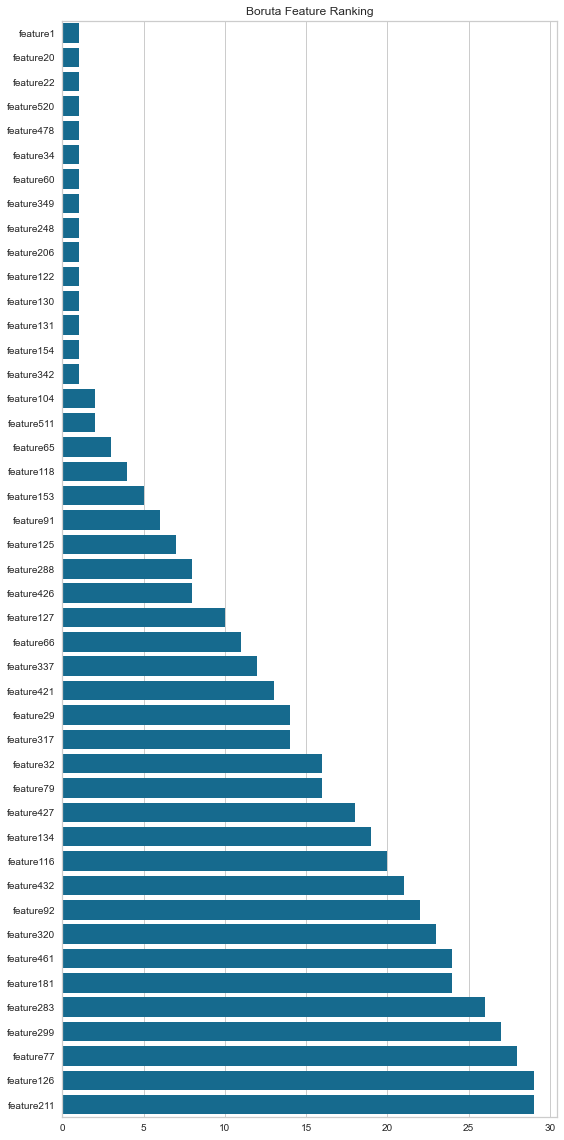

In [47]:
fig,ax = plt.subplots(figsize=(8,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking_30, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
plt.tight_layout()

Text(0, 0.5, '')

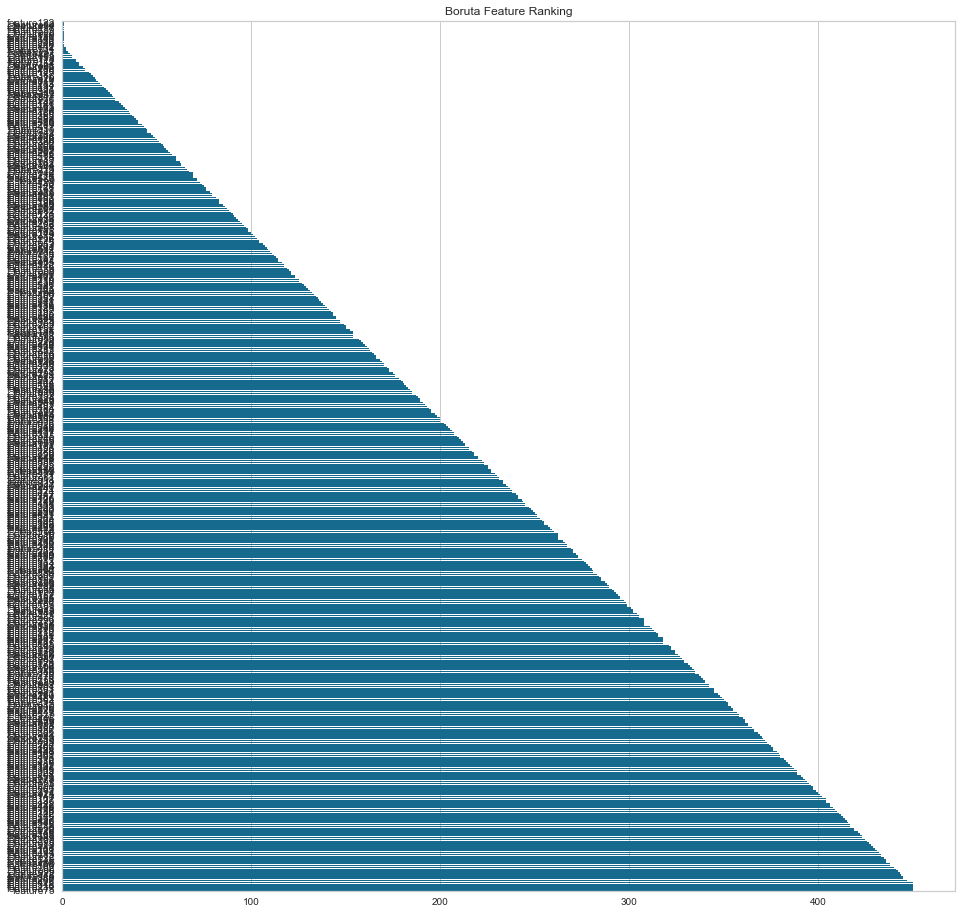

In [95]:
fig,ax = plt.subplots(figsize=(16,16))
ax = sns.barplot(x='values',y='Variable',data=boruta_ranking, color='b')
plt.title('Boruta Feature Ranking')
plt.xlabel('')
plt.ylabel('')
#plt.tight_layout()

# Checking - manual Boruta without the function

In [ ]:
# 
# # prepare the data for boruta by fitting it to random forest Classifier 
#from sklearn.ensemble import RandomForestClassifier

# define random forest classifier
#forest = RandomForestClassifier(n_jobs=-1, class_weight='balanced', max_depth=5)
#forest.fit(imputed_train, y_train)
#iteration=200
# define Boruta feature selection method
#feat_selector = BorutaPy(forest, n_estimators='auto', verbose=2, random_state=1,max_iter=iteration)

# find all relevant features
#feat_selector.fit(np.array(imputed_train),np.array(y_train))
#print("Ranking: ",feat_selector.ranking_)          
#print("No. of significant features: ", feat_selector.n_features_) 
#feat_selector.support_
#green_area = imputed_train.columns[feat_selector.support_].to_list()
#blue_area = imputed_train.columns[feat_selector.ranking_].to_list()
#X_best_features= feat_selector.transform(imputed_train.to_numpy())

# Preparation of test data

## reducing dimensionality

### missing values 

In [62]:
x_test

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,100.0,105.1278,0.1190,1.4615,-0.0109,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,100.0,102.4522,0.1227,1.4444,-0.0014,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,100.0,112.5811,0.1229,1.3838,-0.0125,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,100.0,90.3111,0.1219,1.4844,-0.0288,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,100.0,99.5133,0.1249,1.3331,-0.0126,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,100.0,102.3622,0.1208,1.3952,-0.0198,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,100.0,113.8833,0.1249,1.4294,-0.0014,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,100.0,103.3778,0.1205,1.6486,-0.0239,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,100.0,95.2056,0.1249,1.4939,0.0096,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [50]:
x_test_na = null_values(x_test)

In [51]:
x_test_na

,Missing_Records,Percentage (%)
feature294,285,90.764331
feature293,285,90.764331
feature159,285,90.764331
feature158,285,90.764331
feature493,269,85.668790
...,...,...
feature283,1,0.318471
feature284,1,0.318471
feature285,1,0.318471
feature2,1,0.318471


In [52]:
#x_test_na= x_test_na[x_test_na["Percentage (%)"] > miss_threshold]
#x_test_na
#x_test_new = x_test.drop(axis=1, columns=x_test_na.index)
#x_test_new.shape

,Missing_Records,Percentage (%)
feature294,285,90.764331
feature293,285,90.764331
feature159,285,90.764331
feature158,285,90.764331
feature493,269,85.668790
feature359,269,85.668790
feature221,269,85.668790
feature86,269,85.668790


#### filter featurss of x_train_new only rather than choosing threshold

In [61]:
x_train_new
#x_test_new= x_test[]

,feature1,feature2,feature3,feature4,feature5,feature6,feature7,feature8,feature9,feature10,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
443,3079.77,2354.51,2207.0444,1269.6078,1.7571,100.0,97.0189,0.1221,1.4607,0.0155,...,0.0059,68.7444,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
760,3001.36,2491.23,2155.3111,918.2161,1.2753,100.0,105.0478,0.1227,1.4206,-0.0052,...,NaN,NaN,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
479,3042.78,2377.89,2173.4556,1433.6732,1.0304,100.0,110.5422,0.1245,1.4964,0.0204,...,NaN,NaN,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
362,3018.64,2401.80,2224.0000,1510.0797,1.5611,100.0,99.8300,0.1199,1.4428,-0.0110,...,0.0038,49.7490,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
662,3020.29,2433.99,2217.8111,1744.7771,0.9618,100.0,100.1789,0.1218,1.4950,-0.0097,...,NaN,NaN,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3057.31,2481.53,2214.9333,1663.7024,1.0203,100.0,100.4456,0.1247,1.4830,-0.0328,...,NaN,NaN,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
821,3009.71,2565.53,2224.6778,1308.6479,1.3907,100.0,101.1333,0.1208,1.4440,-0.0079,...,NaN,NaN,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
213,3034.34,2631.47,2179.0445,2028.2208,1.5552,100.0,95.4256,0.1234,1.4281,0.0049,...,NaN,NaN,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1556,3025.21,2503.30,2179.7333,3085.3781,1.4843,100.0,82.2467,0.1248,1.3687,-0.0070,...,0.0016,46.1076,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


### constant volatility 

In [54]:
x_test_new_eda= x_test_new.describe().T
x_test_new_eda

,count,mean,std,min,25%,50%,75%,max
feature1,313.0,3015.805399,72.695332,2787.4900,2968.330000,3011.84000,3057.56000,3266.5500
feature2,313.0,2493.657604,85.188422,2158.7500,2452.280000,2492.81000,2535.71000,2809.7900
feature3,310.0,2201.873688,27.746567,2117.5889,2183.449975,2201.35000,2218.42775,2315.2667
feature4,310.0,1402.265403,462.104127,847.7976,1079.924825,1287.88445,1586.94760,3619.7397
feature5,310.0,4.912465,63.092033,0.7217,1.020325,1.30010,1.52960,1112.1600
...,...,...,...,...,...,...,...,...
feature586,314.0,3.001342,1.035471,1.4716,2.323425,2.79330,3.43675,8.8160
feature587,314.0,0.021208,0.012121,-0.0169,0.014000,0.01995,0.02750,0.0831
feature588,314.0,0.016996,0.009225,0.0032,0.010400,0.01500,0.02120,0.0651
feature589,314.0,0.005425,0.002935,0.0010,0.003300,0.00485,0.00675,0.0212


In [55]:
x_test_new_eda[x_test_new_eda['std']==0]
x_test_new_std= x_test_new_eda[x_test_new_eda["std"] == 0]
x_test_new_std

,count,mean,std,min,25%,50%,75%,max
feature6,310.0,100.0,0.0,100.0,100.0,100.0,100.0,100.0
feature14,313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature43,313.0,70.0,0.0,70.0,70.0,70.0,70.0,70.0
feature50,313.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0
feature53,313.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...
feature535,311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature536,311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature537,311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
feature538,311.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
x_test_new_2 = x_test_new.drop(axis=1, columns=x_test_new_std.index)
x_test_new_2.shape

(314, 460)

### Outlier treatment

In [57]:
x_test_3s=x_test_new_2.copy()

In [58]:
zscore(x_test_3s,x_test_3s.columns,3)

## imputation

### KNN Imputation

In [ ]:
#no need to scale for test data
#x_test_scaled = pd.DataFrame(scaler.fit_transform(x_test_3s), columns=x_test_3s.columns)
#x_test_scaled

In [75]:
x_train_3s_col=x_train_3s.columns

In [76]:
#imputed_test = pd.DataFrame(knn.transform(x_test_3s), columns = x_test_3s.columns)
x_test = x_test.filter(x_train_3s_col)

In [73]:
x_test.filter(x_train_3s_col)

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
1044,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.0060,67.6124,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
607,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,NaN,NaN,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
1332,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,NaN,NaN,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
1220,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.0032,54.1279,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
859,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,NaN,NaN,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
916,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,NaN,NaN,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
1545,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.0070,402.6874,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
54,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.0019,21.9917,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
1051,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,NaN,NaN,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [74]:
x_train_3s

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
443,3079.77,2354.51,2207.0444,1269.607800,1.7571,97.018900,0.1221,1.4607,0.0155,0.0093,...,0.0059,68.7444,0.5001,0.0110,0.0034,2.1899,0.0282,0.0194,0.0059,68.7444
760,3001.36,2491.23,2155.3111,918.216100,1.2753,105.047800,0.1227,1.4206,-0.0052,0.0010,...,NaN,NaN,0.4943,0.0199,0.0042,4.0318,0.0169,0.0276,0.0081,163.9998
479,3042.78,2377.89,2173.4556,1433.673200,1.0304,110.542200,0.1245,1.4964,0.0204,0.0133,...,NaN,NaN,0.4962,0.0114,0.0034,2.2877,0.0208,0.0287,0.0091,138.2861
362,3018.64,2401.80,2224.0000,1510.079700,1.5611,99.830000,0.1199,1.4428,-0.0110,0.0101,...,0.0038,49.7490,0.5047,0.0101,0.0031,1.9927,0.0284,0.0141,0.0038,49.7490
662,3020.29,2433.99,2217.8111,1744.777100,0.9618,100.178900,0.1218,1.4950,-0.0097,-0.0054,...,NaN,NaN,0.5010,0.0147,0.0036,2.9338,0.0165,0.0114,0.0043,68.9871
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
669,3057.31,2481.53,2214.9333,1663.702400,1.0203,100.445600,0.1247,1.4830,-0.0328,0.0048,...,NaN,NaN,0.5037,0.0175,0.0039,3.4736,0.0263,0.0117,0.0033,44.3686
821,3009.71,2565.53,2224.6778,1308.647900,1.3907,101.133300,0.1208,1.4440,-0.0079,-0.0076,...,NaN,NaN,0.4979,0.0078,0.0024,1.5724,0.0275,0.0215,0.0076,78.1199
213,3034.34,2631.47,2179.0445,2028.220800,1.5552,95.425600,0.1234,1.4281,0.0049,0.0092,...,NaN,NaN,0.4968,0.0128,0.0035,2.5829,0.0298,0.0116,0.0039,38.9781
1556,3025.21,2503.30,2179.7333,2704.805249,1.4843,82.357569,0.1248,1.3687,-0.0070,-0.0033,...,0.0016,46.1076,0.5019,0.0158,0.0043,3.1428,0.0120,0.0055,0.0016,46.1076


In [43]:
imputed_test.isna().any().any()

False

In [66]:
imputed_test

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,0.535341,0.587849,0.557956,0.119507,0.000470,0.601001,0.798776,0.546222,0.336676,0.747791,...,0.370158,0.189952,0.459302,0.103298,0.216089,0.100299,0.561771,0.342392,0.377954,0.167735
1,0.537289,0.468819,0.322959,0.154893,0.002790,0.529744,0.885349,0.504749,0.449296,0.503210,...,0.417538,0.300096,0.627907,0.731694,0.589334,0.725170,0.482020,0.306223,0.287245,0.197909
2,0.568034,0.334078,0.627167,0.178692,0.002481,0.799499,0.890029,0.357775,0.317708,0.629899,...,0.333142,0.241469,0.412791,0.275461,0.294667,0.273416,0.524645,0.429195,0.325041,0.226814
3,0.404131,0.657851,0.647724,0.383055,0.007495,0.206399,0.866631,0.601762,0.124475,0.450423,...,0.162870,0.152068,0.645349,0.172163,0.353601,0.165698,0.493020,0.192897,0.166300,0.134282
4,0.279685,0.356519,0.096772,0.204295,0.002383,0.451474,0.936825,0.234811,0.316523,0.635178,...,0.198405,0.139712,0.110465,0.142035,0.216089,0.144559,0.510895,0.267644,0.264568,0.161797
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,0.459201,0.472830,0.428478,0.102445,0.000747,0.527347,0.840893,0.385424,0.231168,0.547199,...,0.241343,0.146843,0.226744,0.180771,0.275023,0.182673,0.593397,0.110916,0.090709,0.068868
310,0.693466,0.494018,0.565899,0.113752,0.005488,0.834180,0.936825,0.468370,0.449296,0.738993,...,0.444190,1.000000,0.186047,0.395975,0.667912,0.402640,0.295016,0.530466,0.453545,0.999002
311,0.350184,0.313712,0.372682,0.197281,0.003555,0.554395,0.833874,1.000000,0.182564,0.555997,...,0.066628,0.061784,0.279070,0.340022,0.451823,0.342331,0.548021,0.053047,0.068032,0.054558
312,0.492307,0.360745,0.539936,0.510572,0.002251,0.336751,0.936825,0.624803,0.579699,0.626380,...,0.319817,0.176831,0.348837,0.202292,0.255378,0.202431,0.323891,0.156729,0.211654,0.288047


## Unscaling of imputed test and filtering the features of test dataset

In [63]:
# unscaling imputed_test
retransformed_test= pd.DataFrame(scaler.inverse_transform(imputed_test), columns=imputed_test.columns)

In [64]:
retransformed_test

,feature1,feature2,feature3,feature4,feature5,feature7,feature8,feature9,feature10,feature11,...,feature581,feature582,feature583,feature584,feature585,feature586,feature587,feature588,feature589,feature590
0,3031.22,2538.56,2211.5222,1079.7336,0.8126,105.1278,0.1190,1.4615,-0.0109,0.0140,...,0.00600,67.612400,0.4998,0.0097,0.0028,1.9366,0.0257,0.0174,0.0060,67.6124
1,3032.07,2477.72,2172.4000,1148.4101,1.2614,102.4522,0.1227,1.4444,-0.0014,0.0001,...,0.00664,106.817780,0.5027,0.0243,0.0047,4.8336,0.0199,0.0159,0.0048,79.7752
2,3045.48,2408.85,2223.0444,1194.5986,1.2016,112.5811,0.1229,1.3838,-0.0125,0.0073,...,0.00550,85.949660,0.4990,0.0137,0.0032,2.7392,0.0230,0.0210,0.0053,91.4264
3,2973.99,2574.34,2226.4667,1591.2235,2.1717,90.3111,0.1219,1.4844,-0.0288,-0.0029,...,0.00320,54.127900,0.5030,0.0113,0.0035,2.2398,0.0207,0.0112,0.0032,54.1279
4,2919.71,2420.32,2134.7445,1244.2899,1.1827,99.5133,0.1249,1.3331,-0.0126,0.0076,...,0.00368,49.729700,0.4938,0.0106,0.0028,2.1418,0.0220,0.0143,0.0045,65.2186
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,2998.01,2479.77,2189.9667,1046.6212,0.8662,102.3622,0.1208,1.3952,-0.0198,0.0026,...,0.00426,52.267940,0.4958,0.0115,0.0031,2.3185,0.0280,0.0078,0.0022,27.7601
310,3100.19,2490.60,2212.8445,1068.5644,1.7835,113.8833,0.1249,1.4294,-0.0014,0.0135,...,0.00700,355.944816,0.4951,0.0165,0.0051,3.3383,0.0063,0.0252,0.0070,402.6874
311,2950.46,2398.44,2180.6778,1230.6762,1.4095,103.3778,0.1205,1.6486,-0.0239,0.0031,...,0.00190,21.991700,0.4967,0.0152,0.0040,3.0587,0.0247,0.0054,0.0019,21.9917
312,3012.45,2422.48,2208.5222,1838.7054,1.1571,95.2056,0.1249,1.4939,0.0096,0.0071,...,0.00532,62.942140,0.4979,0.0120,0.0030,2.4101,0.0084,0.0097,0.0038,116.1088


In [67]:
X_test = retransformed_test.filter(final_features)

In [68]:
X_test

,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature520
0,12.5412,-5287.50,9.4336,-1.2400,15.60,-2.3640,0.7865,9.94,0.018600,3.4391,0.01870,1.4793,6.5927,4.018800
1,12.4922,-5613.50,8.7219,-4.1518,15.92,-0.1419,0.8080,17.13,0.062381,4.7775,0.02690,0.7327,11.9817,13.749382
2,12.5204,-5489.75,9.1637,-5.1491,15.87,-1.2770,0.7223,9.20,0.000000,2.7074,0.02080,0.9544,6.2464,0.000000
3,12.6082,-5100.00,8.8097,-5.6500,15.99,0.0000,0.7672,5.49,0.020200,1.7046,0.02830,0.5319,3.7154,4.331300
4,12.3996,-5416.50,8.2720,5.3973,15.73,-0.5677,0.5325,6.95,0.024340,2.4584,0.02880,0.9850,4.6771,5.309360
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
309,12.5510,-5012.75,8.7635,-1.4027,15.80,-1.7970,0.5662,5.51,0.023820,1.7381,0.01840,1.4588,3.6998,5.196200
310,12.4192,-5338.75,8.1728,4.6964,15.69,0.0000,0.5768,6.25,0.067941,2.0250,0.02502,0.8921,4.1743,14.988822
311,12.4871,-4520.75,9.1784,20.0455,15.87,0.0946,0.7484,9.60,0.195900,2.5763,0.02110,1.2708,6.4725,42.711700
312,12.5661,-5336.75,8.7402,-2.1409,15.78,-3.7790,0.7948,6.62,0.015960,2.0725,0.02290,0.4862,4.4298,3.432520


# Balancing 

In [45]:
def Sampling(X_train, y_train, sampler):
    
    #SMOTE
    if sampler == 'SMOTE':
        sampler = SMOTE(random_state=100)    
    
    #ROSE
    if sampler == 'ROSE':
        sampler = RandomOverSampler(random_state=100, shrinkage=1)

    #ADASYN
    if sampler == 'ADASYN':
        sampler = ADASYN(random_state=100)
    

    #SMOTTEENN
    if sampler == 'SMOTEENN' :
        sampler = SMOTEENN(random_state=100)
        
        
    #Random under Sampling
    if sampler == "randomunder":
        sampler = RandomUnderSampler(random_state=100)

    X_resampled, y_resampled = sampler.fit_resample(X_train, y_train)
    counter = Counter(y_resampled)
    print(counter)
    return X_resampled, y_resampled

In [46]:
X_resampled, y_resampled = Sampling(X_train, y_train,'SMOTE')

Counter({-1: 1170, 1: 1170})


In [47]:
X_resampled

,feature20,feature22,feature34,feature60,feature122,feature130,feature131,feature206,feature248,feature342,feature349,feature427,feature478,feature520
0,12.368600,-4750.750000,8.691500,0.699100,15.760000,0.000000,0.820300,9.220000,0.015200,2.654700,0.023700,1.315500,6.026600,3.292400
1,12.495900,-5410.750000,8.300600,-1.417300,15.760000,0.283800,0.829100,7.310000,0.031060,2.098900,0.027200,0.659300,4.821800,6.713220
2,12.555300,-6456.750000,8.741800,10.235500,15.650000,-0.283800,0.543800,8.800000,0.034500,2.501200,0.016300,1.540300,6.158900,7.439200
3,12.446900,-5775.000000,8.682900,9.851800,15.730000,0.047300,0.804800,7.770000,0.260816,2.432900,0.030000,1.642200,5.061200,61.263283
4,12.461800,-6900.500000,8.589100,1.033600,15.900000,0.425800,0.761100,11.060000,0.017220,3.265300,0.024300,0.800600,7.482800,3.731840
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2335,12.489219,-6415.923312,11.734260,25.670624,15.886523,-0.359906,0.681574,31.624356,0.034554,9.953835,0.024291,1.044275,26.303801,7.395971
2336,12.524649,-5398.137511,8.883645,-1.395501,15.825622,0.907880,0.804828,5.958196,0.043435,1.641890,0.021106,0.770926,4.133259,9.185865
2337,12.493209,-5274.250000,9.094346,-3.399411,15.814912,-0.491810,0.714429,13.452644,0.038135,3.782218,0.024138,0.918683,9.476738,8.158229
2338,12.594568,-5162.360438,8.712101,10.389921,15.801816,0.596983,0.821190,12.833825,0.086584,3.948903,0.038554,1.850067,8.710258,18.158136


# Build Model

## Random forest

### function for running model and printing accuracy score 

In [71]:
def run_model(X, y,X_test,y_test):
    # building model before balancing data
    clf = RandomForestClassifier(random_state=1, n_estimators=1000, max_depth=5)
    clf.fit(X,y)
    y_predicted_test= clf.predict(X_test)
    score1= accuracy_score(y_test, y_predicted_test)
    return score1

In [72]:
#### run model on training data before sampling 
#run_model(imputed_train,y_train,imputed_test,y_test)
# train the model on feature selected X_train and y_train (without sampling ) and test it on prepared test data 
run_model(X_train,y_train,X_test,y_test)

0.9331210191082803

In [73]:
#### run model on training data after sampling 
run_model(X_resampled,y_resampled,X_test,y_test)

0.7961783439490446